In [10]:
from cloud_dataset import CloudDataset
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import torch.nn as nn
import numpy as np
import albumentations as A
import torch.optim as optim
from albumentations.pytorch.transforms import ToTensorV2
import warnings
warnings.filterwarnings("ignore")
import torchvision.transforms as transforms
from PIL import Image as im
from tqdm.notebook import tqdm_notebook
import torch.nn.functional as F

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
BANDS = ["B02", "B03", "B04", "B08"]

In [13]:
train_transforms = A.Compose(
        [
            A.Resize(height=128, width=128),
            A.Rotate(limit=60, p=0.6),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Normalize(
                mean=0.0,
                std=1.0,
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

val_transforms = A.Compose(
    [
        A.Resize(height=128, width= 128),
        A.Normalize(
            mean = 0.0,
            std = 1.0, 
            max_pixel_value = 255.0,
        ),
        ToTensorV2(),
    ]
)

In [14]:
train_x = pd.read_csv("data/train_x.csv").drop(columns = "Unnamed: 0")
train_y = pd.read_csv("data/train_y.csv").drop(columns = "Unnamed: 0")  
val_x = pd.read_csv("data/val_x.csv").drop(columns = "Unnamed: 0")    
val_y = pd.read_csv("data/val_y.csv").drop(columns = "Unnamed: 0")

In [15]:
trainset = CloudDataset(train_x, BANDS, train_y, transforms=train_transforms)
valset = CloudDataset(val_x, BANDS, val_y, transforms=val_transforms)

In [16]:
train_loader = DataLoader(dataset = trainset, batch_size = 64, shuffle=True, pin_memory=True, num_workers=1)
val_loader = DataLoader(dataset = valset, batch_size = 64, shuffle = True, pin_memory=True, num_workers=1)

In [17]:
from focal_loss.focal_loss import FocalLoss

In [20]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=4, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [21]:
def test():
    x = torch.randn((64, 4, 128, 128))
    model = UNET(in_channels=4, out_channels=1)
    preds = model(x)
    print(preds.shape)
    assert preds.shape[0] == x.shape[0]
    assert preds.shape[2] == x.shape[2]
    assert preds.shape[3] == x.shape[3]
    
test()

torch.Size([64, 1, 128, 128])


In [22]:
from tqdm import tqdm
torch.backends.cudnn.benchmark=True

In [23]:
model = UNET(in_channels = 4, out_channels = 1).to(device)

loss_fn = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.0003)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

scaler = torch.cuda.amp.GradScaler()

In [24]:
torch.cuda.empty_cache()

In [25]:
def train_fn(loader, model, optimizer,loss_fn, scaler):
    loadtq = tqdm_notebook(loader, desc = "batches")
    for it in loadtq:
        data = it["chip"]
        targets = it["label"]
        data = data.to(device)
        targets = targets.float().unsqueeze(1).to(device)
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            loss = loss.to(device)
            
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        loadtq.set_postfix(loss=loss.item())

In [ ]:
# num_epoch = 20

# for epoch in tqdm_notebook(range(num_epoch), desc="Epoch: "):
    
#     train_fn(train_loader, model, optimizer, loss_fn, scaler)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

batches:   0%|          | 0/123 [00:00<?, ?it/s]

batches:   0%|          | 0/123 [00:00<?, ?it/s]

batches:   0%|          | 0/123 [00:00<?, ?it/s]

batches:   0%|          | 0/123 [00:00<?, ?it/s]

batches:   0%|          | 0/123 [00:00<?, ?it/s]

batches:   0%|          | 0/123 [00:00<?, ?it/s]

batches:   0%|          | 0/123 [00:00<?, ?it/s]

batches:   0%|          | 0/123 [00:00<?, ?it/s]

batches:   0%|          | 0/123 [00:00<?, ?it/s]

batches:   0%|          | 0/123 [00:00<?, ?it/s]

batches:   0%|          | 0/123 [00:00<?, ?it/s]

batches:   0%|          | 0/123 [00:00<?, ?it/s]

In [43]:
# torch.save(model.state_dict(), "uhuhuhhrtrainmodeltrndunetbceloss.pt")

In [26]:
model.load_state_dict(torch.load("7hrtrainmodeltrndunetbceloss.pt"))

<All keys matched successfully>

In [27]:
torch.cuda.empty_cache()

In [28]:
ehe = 0
for it in val_loader:
    data = it["chip"].to(device)
    pred = model(data)
    true = it["label"].to(device)
    print(it["chip_id"])
    
    print(data.shape)
    print(pred.shape)
    print(true.shape)
    
    ehe+=1
    if(ehe>0): break

['pdcp', 'nnps', 'btbm', 'hsua', 'sbdd', 'appt', 'xltr', 'tihe', 'xadl', 'wkat', 'zwre', 'xheo', 'dtzu', 'vptv', 'dhnh', 'xvew', 'hwhx', 'lxdb', 'cqik', 'ytgv', 'nckw', 'kskj', 'ylth', 'ytqv', 'aqcp', 'hsfa', 'ndzo', 'zctf', 'bjta', 'zcug', 'nnel', 'xufn', 'hsow', 'odes', 'pcpk', 'afxz', 'foyv', 'ktef', 'xsjg', 'svvi', 'hpqn', 'ynjd', 'ddyg', 'clpq', 'ygsh', 'cqbi', 'news', 'atft', 'suwn', 'dzea', 'yblf', 'atna', 'ctzz', 'djte', 'dazo', 'xztf', 'wazt', 'tkhh', 'bjsl', 'ymmb', 'atlg', 'rtcx', 'hnmv', 'gggd']
torch.Size([64, 4, 128, 128])
torch.Size([64, 1, 128, 128])
torch.Size([64, 128, 128])


In [42]:
plt.imshow(true.to("cpu").permute(1, 2, 0)[:, :, 40])

RuntimeError: number of dims don't match in permute

tensor([[-1.6895, -2.3259, -2.4247,  ..., -2.1637, -2.0317, -1.4372],
        [-2.2764, -2.7047, -2.8707,  ..., -2.5671, -2.3541, -2.0715],
        [-2.3023, -2.7032, -2.9910,  ..., -2.8330, -2.5827, -2.2181],
        ...,
        [-2.3308, -2.7172, -2.9469,  ..., -2.1334, -2.3282, -2.2154],
        [-2.2617, -2.5721, -2.8921,  ..., -2.1081, -2.2262, -2.1132],
        [-1.7637, -2.2512, -2.4506,  ..., -2.0488, -2.0870, -1.4998]])

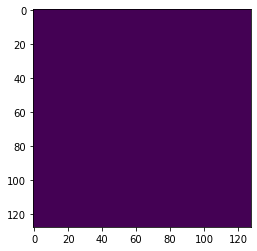

In [47]:
plt.imshow(pred.to("cpu").detach().permute(2, 3, 1, 0)[:, :, 0, 2]>0)
pred.to("cpu").detach().permute(2, 3, 1, 0)[:, :, 0, 2]

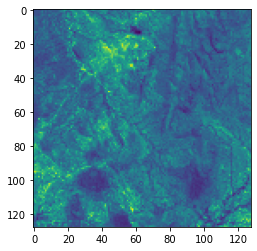

In [46]:
plt.imshow(data.to("cpu").detach().permute(2, 3, 1, 0)[:, :, 0, 2])

In [32]:
true = true.unsqueeze(1)

In [33]:
loss_fn(true, pred)

tensor(-0.8036, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)